# A pragmatist's guide to numerical integration

Preamble: Run the cells below to import the necessary Python packages

*This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.*

In [29]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image


### I have a weird ODE. How do I integrate it?

+ I've spent a lot of time integrating weird ODEs. Today we'll discuss a few tricks I've learned

+ Image below is from Gilpin. NeurIPS 2021. A collection of 132 strange attractors, collected from various historical papers and then integrated using `scipy.solve_ivp`

<img src="../resources/all_attractors.jpg" width="750">

### Some common integrators built into scipy, MATLAB, and Mathematica

```python
from scipy.integrate import solve_ivp

sol = solve_ivp(rhs, [t_start, t_stop], initial_condition, method='RK45', dense_output=True)
```

+ RK45: fast, explicit, embedded (easy to debug)

+ DOP853: fast, explicit, variable-step embedded method (easy to debug)

+ LSODA: switches between Adams-Bashforth and BDF (implicit) depending on the problem stiffness. Defaults to low-level FORTRAN code, and tends to throw weird errors. I avoid it.

+ Radau: implicit, variable-step, high-order

+ BDF: implicit, variable-step, high-order

#### I have personally had best results with Radau for integrating low-dimensional stiff or chaotic systems

## What to do with a real-world ODE

+ Try the built-in solvers in your preferred language

+ Start with RK4(5) or Dormand-Prince 8(3). Crank up the relative and absolute tolerances to $10^{-10}$ or so, until your results look consistent

+ Multiple timescales? Variable step

+ Vectorize the right hand side

+ If using `Radau` or `BDF`, analytically derive the Jacobian, and then pass it to the solver

+ Use drop-in accelerators for numpy (numba or JAX)

+ If working with integro-differential equation (especially non-local), delay equations, stochastic with unusual noise, etc., then you will likely need to write your own solver

# An example problem: integrating a set of coupled oscillators

+ $N$ oscillators with frequency $\omega_i$ and mutual coupling strength $K$
+ $\theta_i(t)$ is the phase of oscillator $i$ at time $t$
+ At small $K$, the oscillators rotate freely. At large $K$, they synchronize
+ The equations of motion are

$$
\dot{\theta}_i = \omega_i + \dfrac{K}{N} \sum_{j=1}^N \sin(\theta_j - \theta_i)
$$


+ Used to describe the dynamics of neurons in the brain, fireflies at dusk, planetary orbits, etc

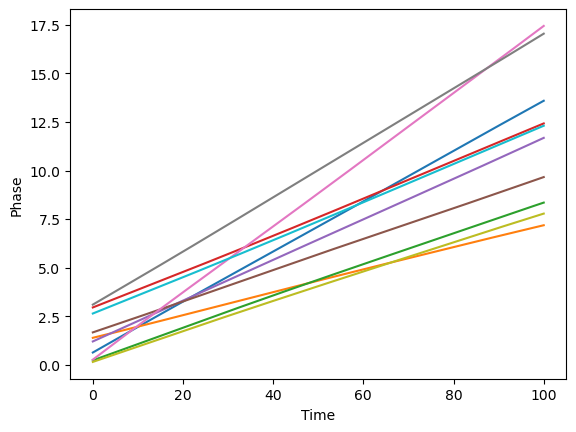

In [35]:
class KuramotoModel:
    """
    Simulate a set of coupled oscillators
    
    Args:
        N (int): Number of oscillators
        K (float): Coupling strength
        w (float): Average natural frequency of single oscillator
        sigma (float): Standard deviation of natural frequencies across oscillator 
            population
    
    """

    def __init__(self, N, K=0.01, w=0.1, sigma=0.03, random_state=None):
        self.N = N
        self.K = K
        self.sigma = sigma
        self.random_state = random_state
        np.random.seed(random_state)
        self.w = np.random.normal(w, sigma, N)

    def rhs(self, t, X):
        """Right-hand side of the Kuramoto model."""
        phase_differences = X[:, None] - X # Use vectorization and broadcasting to compute phase differences
        return self.w + self.K / self.N * np.sum(np.sin(phase_differences), axis=0)

    def __call__(self, t, X):
        return self.rhs(t, X)


eq = KuramotoModel(N=10, K=0.01, sigma=0.03)
ic = np.random.uniform(0, np.pi, eq.N) # initial oscillator phases on half circle

from scipy.integrate import solve_ivp
sol = solve_ivp(eq, (0, 100), ic, method='RK45', t_eval=np.linspace(0, 100, 1000))

plt.plot(sol.t, sol.y.T)
plt.xlabel('Time')
plt.ylabel('Phase')
plt.show()

### Let's see how the timing varies for different numbers of oscillators


In [48]:
%timeit solve_ivp(KuramotoModel(N=10), (0, 100), np.ones(10), method='RK45')

328 µs ± 2.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [50]:
%timeit solve_ivp(KuramotoModel(N=100), (0, 100), np.ones(100), method='RK45')

674 ms ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### These results are pretty bad

+ 10x the oscillators causes a 1000x increase in runtime
+ This is much worse than expected, because the matrix-vector multiplication step inside the model should have time complexity of $O(N^2)$

# Speeding up numerical integration

### Why Python is bad (your advisor wants you to use Fortran)
+ Python Interpreter: translates Python code into bytecode (machine readable) at runtime
+ Python is not a compiled language

### Why Python is good (you want a job after grad school)
+ Python is a high-level language that is easy to read and write
+ Python has a huge ecosystem of packages for scientific computing
+ Python is currently the most popular language for data science and machine learning

### What the Python interpreter does at runtime
+ Dynamic typing: type of variable is determined
+ Garbage collection: remove variables based on reference counting
+ Global interpreter lock: only one thread can run at a time, to avoid incorrect garbage collection due to different threads accessing the same variable

### A workaround: Just-in-time compilation: 
+ Compiles when the code is executed, then caches the compiled code for future calls
+ Identifies types, compiles to machine code local to the machine

# Intrinsic limitations: computer hardware

### The L1 and L2 Cache

+ Memory hierarchy
+ + Registers (64 bit)
+ + L1 Cache (32 KB)
+ + L2 Cache (256 KB/core)
+ + L3 Cache (8 MB)
+ + Main Memory (32 GB)
+ + Disk (1 TB)
+ + Network (1 PB)
+ + Internet (1 EB)

+ Capacity versus latency

+ Image below from [Geeks for Geeks](https://www.geeksforgeeks.org/levels-of-memory-in-operating-system/)

<img src="../resources/computer_memory.png" width="750">

Text(0, 0.5, 'Time (s)')

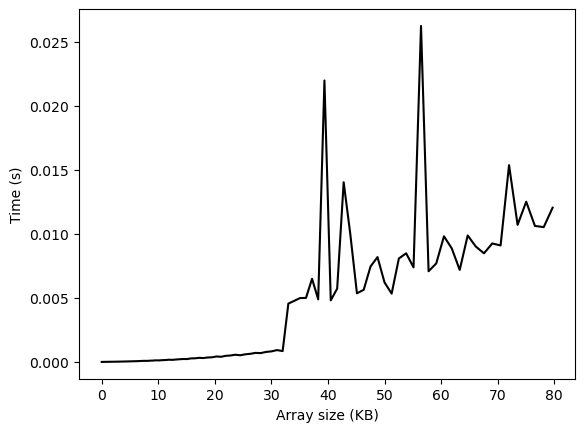

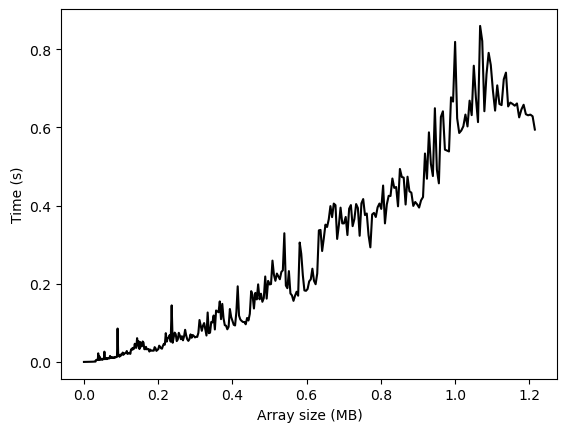

In [68]:
import timeit 
# nvals = (2 + np.logspace(0, 4, 50)).astype(int)
nvals = np.arange(2, 400)
np.random.seed(0)
a0 = np.random.random((nvals[-1], nvals[-1]))
all_times = list()
all_sizes = list()
for n in nvals:
    a = a0[:n, :n]
    t = timeit.timeit("a @ a", globals=globals(), number=n)
    all_reps = list()
    for i in range(10):
        all_reps.append(timeit.timeit("a @ a", globals=globals(), number=n))
    all_times.append(np.mean(all_reps))
    all_sizes.append(a.nbytes) # in MB
all_sizes = np.array(all_sizes)
all_times = np.array(all_times)


plt.figure()
plt.plot(all_sizes[:100] / 1024, all_times[:100], 'k')
plt.xlabel('Array size (KB)')
plt.ylabel('Time (s)')

plt.figure()
plt.plot(all_sizes / 1024**2, all_times, 'k')
plt.xlabel('Array size (MB)')
plt.ylabel('Time (s)')



Text(0.5, 0, 'Array Size (MB)')

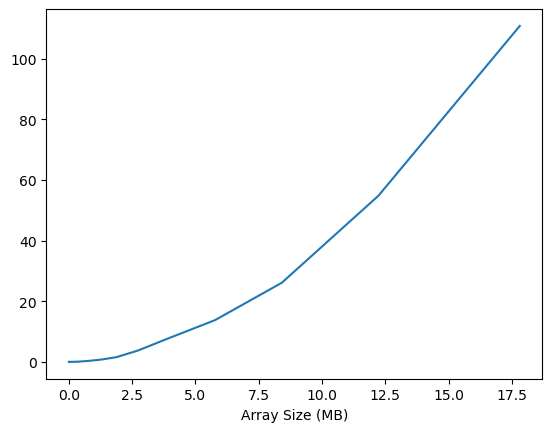

In [59]:
## results from a much longer timing run
plt.plot(all_sizes / 1024**2, all_times)
plt.xlabel('Array Size (MB)')

## Idea: add a Jacobian to the ODE definition

+ We saw that implicit methods can use the Jacobian to improve convergence, potentially allowing larger timesteps without losing accuracy
+ We need to make sure that we choose an implicit solver, which can take advantage of the extra information provided by the Jacobian

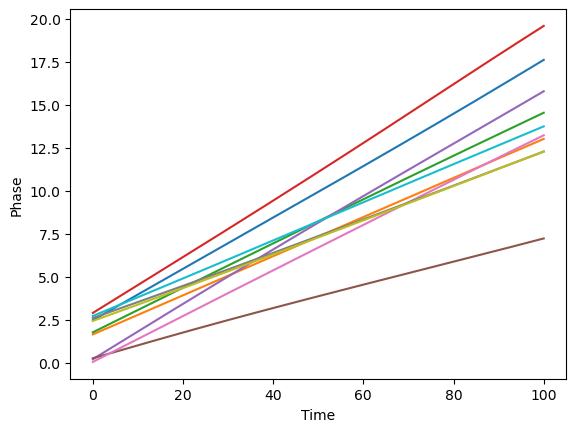

In [97]:
class KuramotoModelJacobian(KuramotoModel):

    def __init__(self,*args, **kwargs):
        super().__init__(*args, **kwargs)
        # This just passes everything to the parent KuramotoModel class

    def jacobian(self, t, X):
        """Jacobian of the Kuramoto model."""
        phase_differences = X[:, None] - X
        return np.diag(self.w) + self.K / self.N * np.sum(-np.cos(phase_differences), axis=0)

kuramoto = KuramotoModelJacobian(N=10, K=0.01, sigma=0.03, random_state=0)
# kuramoto = KuramotoModel(N=10, K=0.01, sigma=0.03, random_state=0)

from scipy.integrate import solve_ivp
ic = np.random.uniform(0, np.pi, eq.N) # initial oscillator phases on half circle

sol = solve_ivp(kuramoto, (0, 100), ic, method="Radau" , jac=kuramoto.jacobian, t_eval=np.linspace(0, 100, 1000))

plt.plot(sol.t, sol.y.T)
plt.xlabel('Time')
plt.ylabel('Phase')
plt.show()


In [101]:
%timeit solve_ivp(kuramoto, (0, 10000), ic, method="Radau" ,jac=kuramoto.jacobian)

559 ms ± 5.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
%timeit solve_ivp(kuramoto, (0, 10000), ic, method="Radau")

23.2 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


+ The Jacobian increases the time per call to the right hand side by a factor of $N^2$, and so it actually increases the total runtime for this problem
+ However, the stability benefits it incurs can help us reduce the required timestep

## Just-in-time compilation with Numba


Upsides:
+ Can be used to accelerate any Python code
+ Can match C performance on subroutines
+ Great for arrays
+ Can be deployed selectively on key subsets of code that need speed

Downsides:
+ Difficult to install (flashbacks to cMake)
+ Limited to a subset of Python operations

#### How it works

+ Python bytecode -> LLVM IR -> machine code

+ First call: 
    1. Infer argument types and identify common structures like list comprehensions, dot products, etc
    2. Generate a "compile-ready" form in language-independent syntax (intermediate representations)
    3. Compile the code to machine code (LLVM: IR --> Machine code)
    4. Cache the compiled code for future use

+ Subsequent calls: run compiled code directly

+ Image below from [Towards Data Science](https://towardsdatascience.com/why-numba-sometime-way-slower-than-numpy-15d077390287)

<img src="../resources/numba_diagram.png" width="750">

There are a few quirks to using numba and other JIT compilers for Python. Generally, since they need to convert our code to machine code, they need to know the types of the variables, or at least be able to easily infer their type from context. Additionally, they do not work well with abstract data types like user-defined objects, and they also don't always work with mutable objects of variable length, like lists. 

All of these drawbacks arise from the explicit memory management and static types requires to obtain the performance gains of compiled code.

In [76]:
from numba import njit

class KuramotoModelNumba(KuramotoModel):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        ## These lines just pass the arguments and keyword arguments to the parent class

    @staticmethod
    @njit
    def _rhs(t, X, K, N, w):
        phase_differences = X.reshape((1, -1)) - X.reshape((-1, 1))
        return w + K / N * np.sum(np.sin(phase_differences), axis=0)

    def rhs(self, t, X):
        return self._rhs(t, X, self.K, self.N, self.w)

        
        

In our updated class, we first delegate all of the construction and instance variable assignment to the parent class. We then define an explicit method for the right hand side of the ODE, which we tell numba to compile using the `@njit` decorator. 

Because numba does not work well with abstract objects, notice that we apply the @staticmethod decorator to the `_rhs` method, which tells Python that this function does not require any of the information in the `self` object. Instead, we pass parameter values explicitly to the method as arguments.

In order to access the compiled numba function `_rhs` from a familiar API, we next overwrite the parent class `rhs` method with a new method, which passes various attributes associated with `self` to the compiled `_rhs` method as explicit arguments.

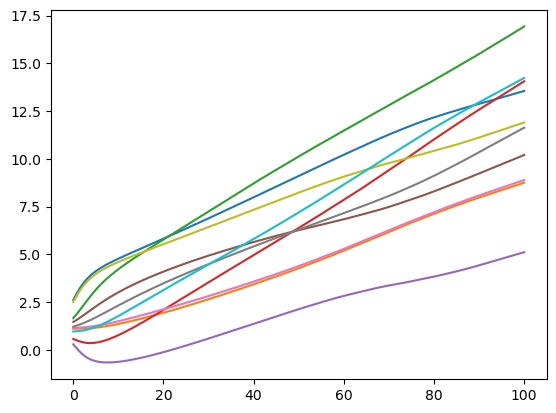

In [82]:
eq = KuramotoModelNumba(N=10, K=0.5, sigma=0.03)

from scipy.integrate import solve_ivp
ic = np.random.uniform(0, np.pi, eq.N) # initial oscillator phases on half circle

sol = solve_ivp(eq, (0, 100), ic, method='RK45', t_eval=np.linspace(0, 100, 1000))

plt.plot(sol.t, sol.y.T)

In [85]:
%timeit solve_ivp(KuramotoModel(N=50, K=0.5), (0, 10000), np.ones(50))

156 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [84]:
model = KuramotoModelNumba(N=50, K=0.5)
model.rhs(0, np.ones(50))
%timeit solve_ivp(model, (0, 10000), np.ones(50))

124 ms ± 897 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Cython

+ Cython is a superset of Python that adds static typing

+ Cython code is compiled to C, which is then compiled to machine code

+ Image below from [Cardinal Peak](https://www.cardinalpeak.com/blog/faster-python-with-cython-and-pypy-part-1)

<img src="../resources/cython_code.png" width="750">


### Upsides

+ Compiles Python code to C
+ A "super-set" of Python that allows you to write C-like code, call C functions, and use C data types
+ Will fall back to Python if you use unsupported features or have mixed types

### Downsides

+ Some install complications
+ Loses the readability and extensibility of pure Python
+ Not as easy to use as Numba
+ Many external libraries are not compatible with Cython
+ Appears to be declining in popularity among the scientific Python community


### My biased opinion: Try Numba or JAX first, otherwise just directly use C or Julia

## JAX

+ Newest technology here
+ Converts Python code to XLA (Accelerated Linear Algebra)
+ XLA is a domain-specific language for linear algebra. Newer approach than LLVM
+ Backed by Google
+ First-class support for automatic differentiation

### My biased opinion: This is the future of scientific computing in Python

In [26]:
import jax.numpy as jnp

class KuramotoModelJax(KuramotoModel):
    """
    The Kuramoto model with key methods written in jax.numpy
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        ## These lines just pass the arguments and keyword arguments to the parent class

    def rhs(self, t, X):
        """Right-hand side of the Kuramoto model."""
        phase_differences = X[:, None] - X # Use vectorization and broadcasting to compute phase differences
        return self.w + self.K / self.N * jnp.sum(jnp.sin(phase_differences), axis=0)

    def __call__(self, t, X):
        return self.rhs(t, X)



In [12]:
eq = KuramotoModel(N=150)
%timeit solve_ivp(eq, (0, 100), np.ones(150), method='RK45')

14.1 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
eq = KuramotoModelJax(N=150)
%timeit solve_ivp(eq, (0, 100), jnp.ones(150), method='RK45')

6.51 ms ± 94.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Further optimizations are possible here. We are wasting a lot of compute unpacking arguments, etc, and scipy.solve_ivp returns a numpy array, which has to silently be converted to a JAX array (and back) at each timestep. There are specialized integrators written directly in JAX which would speed this up even more.

### Automatic differentiation

+ Built into JAX
+ Other automatic differentiation libraries exist: PyTorch, TensorFlow, Flux.jl (Julia)
+ Optimizaton: computing gradients and Hessians by hand is tricky and error-prone
+ Finite-differences are inexact and scale as O(d^2), where $d$ is the dimensionality of the ODE or optimization setting
+ Automatic differentiation is exact and scales as O(d)

Idea: most functions are composed of a small number of elementary operations, like addition, multiplication, exponentiation, etc. We can use the chain rule to compute the derivative of a function by computing the derivative of each elementary operation, and then composing them together.

In [ ]:
def double_well(x):
    """Double well potential function"""
    return x**4 - 2*x**2

def double_well_grad(x):
    """Derivative of double well potential function"""
    return 4*x**3 - 4*x

def double_well_hess(x):
    """Hessian of double well potential function"""
    return 12*x**2 - 4



Let's perform this calculation a little more explicitly

In [ ]:
def double_well_primitive(x):
    """Decompose the double well calculation into primitive operations"""
    h1a = x**4
    h1b = 2*x**2
    h2 = h1a - h1b
    return h2

def double_well_primitive_grad(x):
    """Decompose the double well gradient calculation into primitive operations"""
    dh2dh1a = 1
    dh2dh1b = -1
    dh1adx = 4*x**3
    dh1bdx = 4*x
    dh2dx = dh2dh1a * dh1adx + dh2dh1b * dh1bdx
    return dh2dx

We can see that even elaborate calculations decompose into simple operations, which get fed forward and composed through downstream simple operations. In order to find the derivative, we traverse this tree of operations in reverse

Automatic differentiation packages take our functions, and build this tree of operations, allowing it to later trace the tree in reverse to compute exact gradients. They can gain further speedups by "caching" the results of forward calculations during the forward pass, since something the forward values get reused in the reverse pass.

# Julia

### Upsides

+ A new language that is designed to be fast
+ Compiles to LLVM
+ Has a lot of the same features as Python, fixes some of the weird syntax of Python
+ First class support for parallelism, distributed computing, GPU acceleration, and automatic differentiation
+ Performs very favorably against Python, MATLAB, etc in benchmarks. Competitive with C and Fortran, but with more Python-like syntax

### Downsides

+ Not yet widely used outside of scientific computing community
+ Not yet as many libraries or developers as Python.
+ Documentation improving, but still not equal to core Python libaries


### My biased opinion: Probably worth learning (likely has a bright future in scientific computing). But you still need to know Python for now